In [1]:
import numpy as np
from scipy.stats import pearsonr, entropy
from scipy.special import kl_div
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import functions as f # My functions
from scipy.stats import ks_2samp

# Context

Correlation only captures linear relationships between random variables and is sensitive to outliers. Furthermore, it is not a true metric, which can lead to unintuitive results.

In this context, we will explore alternative measures of dependence, many of which are based on information theory. These measures will be tested on synthetic data, followed by an application to market quotes, where correlation may have failed to detect underlying dependencies.

# Measures based on correlation

If $\rho(X, Y)$ is the correlation between random vectors $X$ and $Y$, then $d_\rho (X, Y) = \sqrt{\frac{1}{2}(1-\rho(X, Y))}$ is a metric. 

In [2]:
def corr_metric(X, Y):
    # Metric based on correlation

    corr, _ = pearsonr(X, Y)
    metric = np.sqrt((1 - corr) / 2)
    
    return metric

X = np.array([2, 1, 0, -1, -2])
Y = np.array([2, 1, 0, 1, 2])
Z = np.array([-2, -1, 0, 1, 2])

print(corr_metric(X, X))
print(corr_metric(X, Y))
print(corr_metric(X, Z))

0.0
0.7071067811865476
1.0


Also $d_\rho (X, Y) = \sqrt{\frac{1}{2}(1-|\rho(X, Y)|)}$ is a metric - this one will consider highly negatively correlated portfolios as being close to each other.

In [3]:
def abs_corr_metric(X, Y):
    # Metric based on correlation

    corr, _ = pearsonr(X, Y)
    metric = np.sqrt(1 - np.abs(corr))
    
    return metric

X = np.array([2, 1, 0, -1, -2])
Y = np.array([2, 1, 0, 1, 2])
Z = np.array([-2, -1, 0, 1, 2])

print(abs_corr_metric(X, X))
print(abs_corr_metric(X, Y))
print(abs_corr_metric(X, Z))

0.0
1.0
0.0


# Measures base on information theory

The below Venn diagram shows all the metrics.

<!-- <img src="info theory, cred Wiki, CC BY-SA 40.png" width="500"/> -->

<img src="info_theory_cred_Wiki.png" width="500"/>

We assume to have two discrete random variables, defined on the same probability space:
* $X$ with values $x \in S_X$ and probabilities $p(x)$
* $Y$ with values $y \in S_Y$ and probabilities $q(y)$
* $(X, Y)$ has a joint distribution $p(x,y)$

## Marginal entropy <i>H(X)</i>

Marginal entropy measures the uncertainty, or expected surprise, in a probability distribution:

$H(X) = -\sum_{x \in S_X} p(x) \ln (p(x))$

The value $\frac{1}{p(x)}$ measures how surprising an observation is, as low probability events are more surprising. The logarithm ensures that $p(x)$ and $\frac{1}{p(x)}$ do not cancel each other out. It is zero for a single element distibution, and reaches maximum for a uniform distribution.

## Joint entropy <i>H(X,Y)</i>

$H(X,Y)=-\sum_{x, y \in S_X \times S_Y} p(x, y) \ln (p(x, y))$

If $X$ and $Y$ are independant, $H(X,Y) = H(X) + H(Y)$.

## Conditional entropy <i>H(X|Y)</i>

Measures the uncertainty we expect in $X$ if we know the value of $Y$:

$H(X|Y)=H(X,Y)-H(Y)=-\sum_{y \in S_Y} q(y) \sum_{x \in S_X} p(x|Y=y) \ln (p(x|Y=y)) = -\sum_{x,y \in S_X \times S_Y} p(x,y) \ln \frac{p(x,y)}{q(y)}$

## Kullback-Leibler (KL) divergence

Measures how much $p$ diverges from the reference distribution $q$:

$D_{KL}(p||q) = \sum_{x \in S_X} p(x) \ln ( \frac{p(x)}{q(x)} )$

We assume $p(x)=0$ if $q(x)=0$. $D_{KL}(p||q) \neq D_{KL}(q||p)$, but we can use symetric alternatives, like the Jensen-Shannon divergence.

## Cross-entropy

Measures the cost of using a wrong distribution $q$ instead of the real distribution $p$:

$H_{C}(p||q) = -\sum_{x \in S_X} p(x) \ln ( {q(x)} ) = H(X) + D_{KL}(p||q)$

We assume $p(x)=0$ if $q(x)=0$. It is often used as a loss function in machine learning.

## Mutual information <i>I(X,Y)</i>

Measures how much knowing the value of $Y$ reduces the uncertainty about $X$:

$I(X,Y)=H(X)-H(X|Y)=H(X)+H(Y)-H(X,Y)=\sum_{x,y \in S_X \times S_Y} p(x,y) \ln ( \frac{p(x,y)}{p(x)q(y)} )$

## Variation of information <i>VI(X,Y)</i>

Measures how different two probability distributions or clusterings are:

$VI(X,Y)=H(X|Y)+H(Y|X)=H(X)+H(Y)-2I(X,Y)=2H(X,Y)-H(X)-H(Y)=H(X,Y)-I(X,Y)$

$VI(X,Y)=0$ if and only if $X=Y$. It is a (true) metric.

It is dependent of population size, so a bounded version is often used:

$VI_B(X,Y)=\frac{VI(X,Y)}{H(X,Y)}$

# The continuous case

These concepts extend to the continuous case. For example, the differential entropy of a random variable $X$ with support $S_X$ and probability density function $f$ is defined as:

$h(X) = -\int_{S_X}f(x)\ln( f(x))dx$

It does not share all properties of discrete entropy, for example it is not invariant under coordinate transformations.

To approximate differntial entropy (or any of the other metrics) from data, a discretization approach can be used:

- Divide the support into buckets of size $\Delta x$.

- Approximate the density function as $f(x) \approx \frac{N_i}{N} \frac{1}{\Delta x}$, where $N_i$ is the amount of observations in bucket $i$ and $N$ is the total amount of observations.

- Calculate the entropy estimate as: $h(X) \approx -\sum_{i} \frac{N_i}{N} \frac{1}{\Delta x} \ln(\frac{N_i}{N} \frac{1}{\Delta x}) \Delta x = -\sum \frac{N_i}{N} \ln(\frac{N_i}{N}) + \ln(\Delta x)$

This formulation highlights a dependence on the bin size, making absolute values of differential entropy less meaningful. On the other hand, relative measures such as KL divergence and mutual information remain useful, as they compare distributions rather than relying on absolute entropy values. Similiarly, cross-entropy is used to measure how well a model distribution approximates the true distribution.

In [4]:
def discretize_distributions(x, y, same_bins = False, bins = None):
    # Discretize distributions, using the same support or not for both dimenstions

    x = np.asarray(x)
    y = np.asarray(y)

    if bins is None:
        n_obs = len(x)
        # Optimal amount of bins for entropy
        bins_1D = (8 + 324 * n_obs + 12 * (36 * n_obs + 729 * n_obs**2)**0.5)**(1/3)
        bins_1D = round(bins_1D/6 + 2/3/bins_1D + 1/3)
        # Optimal amount of bins for joint entropy
        corr, _ = pearsonr(x, y)
        corr = np.clip(corr, -0.90, 0.90) # Debugging perfectly correlated variables
        bins_2D = round(2**-0.5 * (1 + (1 + 24 * n_obs/(1 - corr**2))**0.5)**0.5)
    else:
        bins_1D, bins_2D = bins, bins

    if same_bins:
        bin_edges_1D = np.histogram_bin_edges(
            np.concatenate((x, y)), bins=bins_1D) # Ensure the same support for X and Y
        p_x, bins_x = np.histogram(x, bins=bin_edges_1D, density=False)
        p_x = np.asarray(p_x, dtype=np.float64)
        p_x /= np.sum(p_x)
        q_y, bins_y = np.histogram(y, bins=bin_edges_1D, density=False)
        q_y = np.asarray(q_y, dtype=np.float64)
        q_y /= np.sum(q_y)
        p_xy, bins_xy_x, bins_xy_y = np.histogram2d(x, y, bin_edges_1D, density=False)
        p_xy = np.asarray(p_xy, dtype=np.float64)
        p_xy /= np.sum(p_xy)
    else:
        p_x, bins_x = np.histogram(x, bins_1D, density=False)
        p_x = np.asarray(p_x, dtype=np.float64)
        p_x /= np.sum(p_x)
        q_y, bins_y = np.histogram(y, bins_1D, density=False)
        q_y = np.asarray(q_y, dtype=np.float64)
        q_y /= np.sum(q_y)
        p_xy, bins_xy_x, bins_xy_y = np.histogram2d(x, y, bins_2D, density=False)
        p_xy = np.asarray(p_xy, dtype=np.float64)
        p_xy /= np.sum(p_xy)

    bin_size_x = np.diff(bins_x)[0]
    bin_size_y = np.diff(bins_y)[0]
    bin_size_xy = np.diff(bins_xy_x)[0] * np.diff(bins_xy_y)[0]

    return p_x, q_y, p_xy, bin_size_x, bin_size_y, bin_size_xy


def entropy_metrics(x, y, same_bins = True, bins = None):
    # Computes entropy-based measures using discretization:
    # - Marginal entropies: H(X), H(Y)
    # - Joint entropy: H(X, Y)
    # - Conditional entropies: H(X|Y), H(Y|X)
    # - Mutual information: I(X, Y)
    # - Variation of information (VI) and its bounded form (VIB)

    x = np.asarray(x)
    y = np.asarray(y)

    p_x, q_y, p_xy, bin_size_x, bin_size_y, bin_size_xy = \
        discretize_distributions(x, y, same_bins = same_bins, bins = bins) # ! Could be set to False

    H_X = entropy(p_x) + np.log(bin_size_x) # H(X)
    H_Y = entropy(q_y) + np.log(bin_size_y) # H(Y)
    H_XY = entropy(p_xy.flatten()) + np.log(bin_size_xy) # H(X, Y)
    H_X_cond_Y = H_XY - H_X # H(X|Y)
    H_Y_cond_X = H_XY - H_Y # H(Y|X)
    I_XY = H_X + H_Y - H_XY # I(X, Y)
    VI_XY = 2*H_XY - H_X - H_Y # VI(X, Y)
    VIB_XY = VI_XY / H_XY # Bounded VI(X, Y)

    return H_X, H_Y, H_XY, H_X_cond_Y, H_Y_cond_X, I_XY, VI_XY, VIB_XY


def kl_metrics(x, y, ensure_same_support = True, bins = None):
    # Computes Kullback-Leiber divergence and cross-entropy

    p_x, q_y, _, bin_size_x, bin_size_y, _ = \
        discretize_distributions(x, y, same_bins = True, bins = bins) # We need the same bins by definition

    if not ensure_same_support:
        KL_div = np.sum(kl_div(p_x, q_y)) # Kullback-Leiber divergence, same bins in both dimensions, so it's bin size invariant
    else:
        # Option 1
        valid_mask = (p_x > 0) & (q_y > 0) # Prevent 0 division and log(0)
        p_x = p_x[valid_mask]
        q_y = q_y[valid_mask]
        KL_div = np.sum(p_x * np.log(p_x / q_y)) # If we want to prevent 0 division
        # Option 2
        # eps = 1e-10  # Small constant to avoid log(0)
        # p_x = np.clip(p_x, eps, None)  # Ensures p_x is not exactly zero
        # q_y = np.clip(q_y, eps, None)  # Ensures q_y is not exactly zero
        # KL_div = np.sum(p_x * np.log(p_x / q_y))

    H_X = entropy(p_x) + np.log(bin_size_x)

    H_C_pq = H_X + KL_div # Cross-entropy

    return KL_div, H_C_pq

In [5]:
# Check: we know that the theoretical entropy of N(0,1) is 1.4189
print(f'Precise  {1 / 2 * np.log(2 * np.pi * np.e)}')
x = np.random.normal(loc=0, scale=1, size=252) # 1 Y of data
print(f'252 obs. {entropy_metrics(x, x)[0]}')
x = np.random.normal(loc=0, scale=1, size=1000000) # 1 Y of data
print(f'1M obs.  {entropy_metrics(x, x)[0]}')

Precise  1.4189385332046727
252 obs. 1.417910014972242
1M obs.  1.4183370356946328


# Comparing metrics across multiple scenarios

We will analyse how these metrics perform on synthetic data, leveraging Taylor’s theorem that polynomial approximations provide insights across a broad range of functions. Our examination will cover both a normal distribution and a fat-tailed (log-normal) distribution.

Next, we will apply these metrics to real-world stock returns, where traditional correlation measures may have failed to capture codependencies.

In [6]:
def normalize(x):
    return (x - np.mean(x)) / np.std(x)


def polynomials(x, eps):
    y1 = eps                      # Independent random variables
    y2 = normalize(x + eps / 10)  # Near identity
    y3 = normalize(x + eps)       # Linear
    y4 = normalize(x**2 + eps)    # Quadratic
    y5 = normalize(x**3 + eps)    # Cubic
    y6 = normalize(x**4 + eps)    # Quartic

    data = {"y1 (Independent)": y1, 
            "y2 (Near Identity)": y2, 
            "y3 (Linear)": y3, 
            "y4 (Quadratic)": y4, 
            "y5 (Cubic)": y5,
            "y6 (Quartic)": y6}

    # Scatterplots
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()
    for ax, (label, y) in zip(axes, data.items()):
        sns.scatterplot(x=x, y=y, ax=ax, alpha=0.5)
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

    return data

### Normal distribution

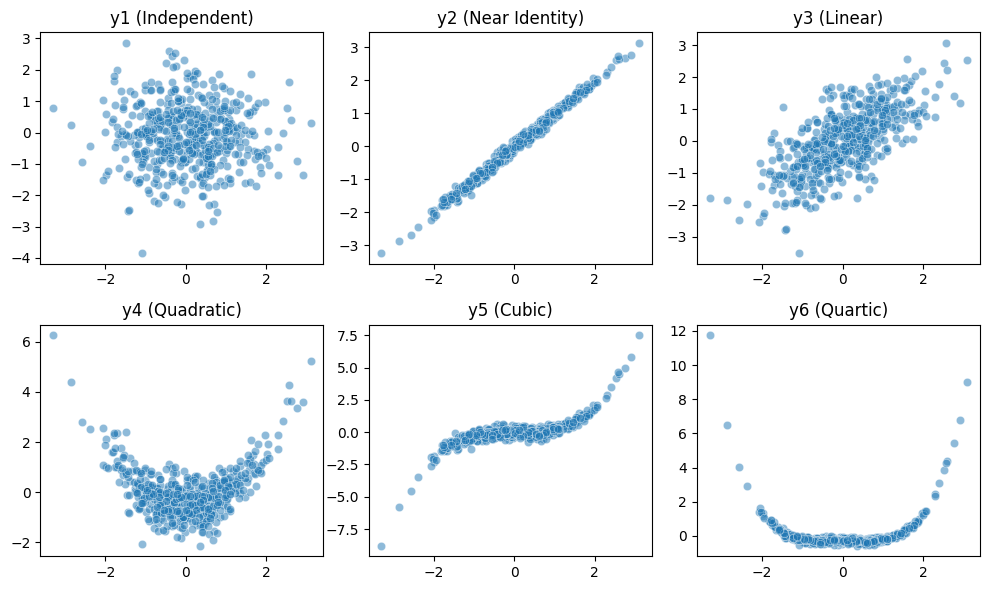

,y1 (Independent),y2 (Near Identity),y3 (Linear),y4 (Quadratic),y5 (Cubic),y6 (Quartic)
"Corr(X, Y)",-0.03,1.00,0.70,0.05,0.74,0.08
Corr metr.,0.72,0.05,0.39,0.69,0.36,0.68
H(X),1.41,1.42,1.41,1.45,1.46,1.47
H(Y),1.41,1.42,1.42,1.33,1.03,0.65
"H(X, Y)",2.73,1.34,2.47,2.40,2.14,1.89
H(X|Y),1.32,-0.07,1.05,0.95,0.68,0.42
H(Y|X),1.32,-0.08,1.05,1.08,1.11,1.24
"I(X, Y)",0.09,1.50,0.37,0.37,0.35,0.23
"VI(X, Y)",2.64,-0.15,2.10,2.03,1.79,1.66
"VIB(X, Y)",0.97,-0.11,0.85,0.84,0.84,0.88


In [7]:
# Generating data
np.random.seed(21)
x = np.random.normal(loc=0, scale=1, size= 2 * 252)  # N(0,1) sample, 2 years of observations
eps = np.random.normal(loc=0, scale=1, size=len(x))  # Noise

data = polynomials(x, eps)

# Printing the metrics
results = {}
for label, y in data.items():
    corr0, _ = pearsonr(x, y)
    corr_metric0 = corr_metric(x, y)
    entropy_metrics0 = entropy_metrics(x, y, same_bins = True)
    kl_metrics0 = kl_metrics(x, y)
    results[label] =  (round(corr0, 2),) + (round(corr_metric0, 2),) + \
        tuple(round(value, 2) for value in entropy_metrics0) + tuple(round(value, 2) for value in kl_metrics0)

columns = ["Corr(X, Y)", "Corr metr.", "H(X)", "H(Y)", "H(X, Y)", "H(X|Y)", "H(Y|X)", "I(X, Y)", "VI(X, Y)", "VIB(X, Y)", "KL div", "Cross-entr."]
df = pd.DataFrame(results, index=columns)

df

Observations:

- If we don't normalize the distributions, the differing scales make the metrics unintuitive.

- The correlation metric fails to capture powers of even numbers, causing it to show these variables as distant despite their relationship.

- $H(X)$ varies in different scenarios. This is due to the choice of setting <i>same_bins = True</i> in the function <i>entropy_metrics</i>. This decision was made based on the improved overall performance of the metrics under such a setup.

- Many metrics behave counterintuitively in the near-identity scenario, such as when the conditional entropy $H(Y|X)$ becomes negative. This is an edge case where the binning techniques seem to fail.

- The conditional entropy $H(Y|X)$ is largest in the independent scenario, and it decreases linearly with the polynomial degree, making it a useful benchmark for the potential of $X$ to explain $Y$.

- Mutual information, $I(X,Y)$, is effective at detecting dependencies between variables.

- Variation of information, $VI(X,Y)$, clearly identifies the independent variables case as the furthest apart.

- The KL divergence is near 0 in both the independent and near-identity scenarios. It effectively shows how similar the distributions are, but does not reveal the dependency between the variables.

- When analyzing samples of 252 and 1000 observations, the observations were slightly different. Therefore, caution should be exercised before drawing any definitive conclusions.

### Fat tailed t-student distribution

Not going into a larger analysis, we can see that the measures work also for other distributions.

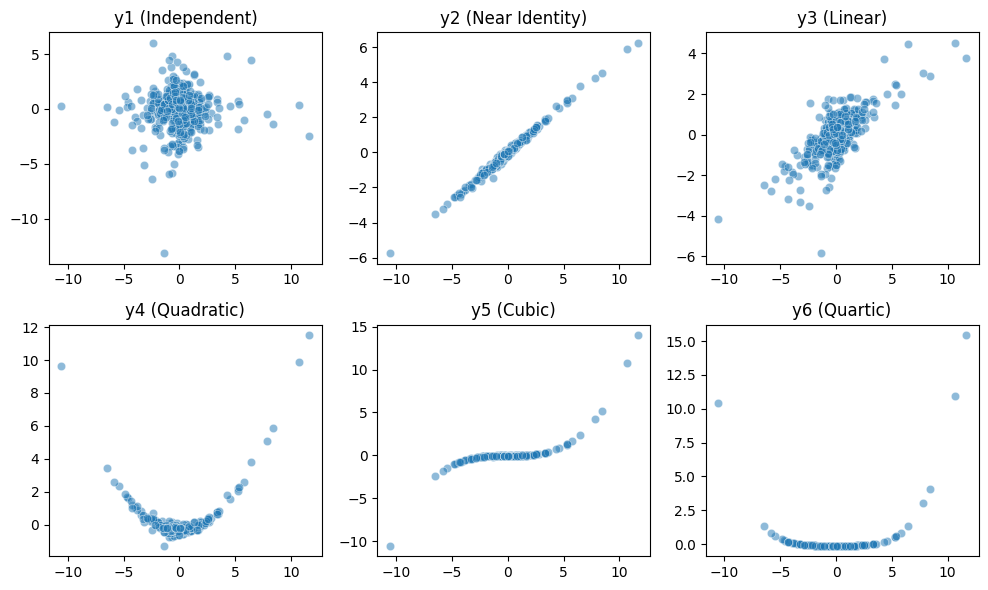

,y1 (Independent),y2 (Near Identity),y3 (Linear),y4 (Quadratic),y5 (Cubic),y6 (Quartic)
"Corr(X, Y)",0.02,1.00,0.75,0.23,0.67,0.27
Corr metr.,0.70,0.04,0.35,0.62,0.41,0.60
H(X),1.88,1.90,1.90,1.90,1.92,1.96
H(Y),1.84,1.44,1.53,0.92,0.95,0.94
"H(X, Y)",3.68,2.75,3.13,2.56,2.68,2.75
H(X|Y),1.80,0.85,1.23,0.67,0.76,0.78
H(Y|X),1.84,1.31,1.60,1.64,1.72,1.81
"I(X, Y)",0.04,0.59,0.30,0.25,0.19,0.15
"VI(X, Y)",3.64,2.16,2.83,2.31,2.48,2.59
"VIB(X, Y)",0.99,0.79,0.90,0.90,0.93,0.94


In [8]:
# Generating data
np.random.seed(21)
x = np.random.standard_t(df=3, size=2 * 252)  # Log-normal sample
eps = np.random.standard_t(df=3, size=len(x)) # Noise

data = polynomials(x, eps)

# Printing the metrics
results = {}
for label, y in data.items():
    corr0, _ = pearsonr(x, y)
    corr_metric0 = corr_metric(x, y)
    entropy_metrics0 = entropy_metrics(x, y, same_bins = True)
    kl_metrics0 = kl_metrics(x, y)
    results[label] =  (round(corr0, 2),) + (round(corr_metric0, 2),) + \
        tuple(round(value, 2) for value in entropy_metrics0) + tuple(round(value, 2) for value in kl_metrics0)


# Convert the dictionary into a DataFrame for better display
columns = ["Corr(X, Y)", "Corr metr.", "H(X)", "H(Y)", "H(X, Y)", "H(X|Y)", "H(Y|X)", "I(X, Y)", "VI(X, Y)", "VIB(X, Y)", "KL div", "Cross-entr."]
df = pd.DataFrame(results, index=columns)

df

# Application to market data

We will now run some tests on market data.

1. First we will examine asset pairs with the highest mutual information among those with very weak correlations (below 0.05) to assess whether mutual information captures dependencies that correlation overlooks.

2. We will examine a scatterplot of correlation against mutual information, to check if mutual information is good at picking the linear relationships between data.

Our analysis is based on normalized data with the most extreme outliers removed. However, we did not convert all assets to a common currency, as this is only a preliminary exploration of the data.

### Selecting the data

In [9]:
# Choosing the stocks and calculating their log returns
df_stocks_info = pd.read_csv('stocks_info.csv')

# typeDisp can be 'Equity', 'Currency', 'Cryptocurrency', 'Index', 'Futures'
chosen_assets = df_stocks_info[df_stocks_info['typeDisp'].isin(['Currency', 'Index'])]['symbol']

df_returns = f.calculate_returns(chosen_assets=chosen_assets, print_high_corr=False)
# df_returns = df_returns.iloc[-322:,:] # Last 2 years of data
df_returns

Symbol,000001.SS,AUDUSD=X,CNY=X,EURCAD=X,EURCHF=X,EURGBP=X,EURHUF=X,EURJPY=X,EURSEK=X,EURUSD=X,...,^FVX,^GDAXI,^GSPC,^HSI,^IRX,^IXIC,^N225,^STOXX50E,^TNX,^TYX
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-07,-0.012285,-0.000993,0.001435,0.001207,0.000028,-0.003887,0.000109,0.007103,0.002023,0.003223,...,0.004954,0.007033,-0.002807,-0.008301,0.008032,-0.000319,-0.015860,0.003534,0.008796,0.010467
2020-01-08,0.009085,-0.011149,-0.004325,-0.000710,-0.003381,0.000647,0.005833,-0.007236,0.003568,-0.003870,...,0.028016,0.013044,0.004890,0.016703,-0.004678,0.006667,0.022798,0.006162,0.025400,0.022733
2020-01-09,-0.000838,0.001952,0.000115,-0.001380,0.000897,-0.003097,-0.001927,0.005661,-0.005536,-0.003730,...,-0.006024,-0.000871,0.006633,0.002699,0.004678,0.008094,0.004652,-0.001677,-0.008574,-0.011946
2020-01-13,0.004687,0.003891,-0.005182,0.002806,0.000194,0.004976,0.008362,0.005128,0.005528,0.000311,...,-0.002420,-0.001991,0.004093,0.008586,0.006645,0.007631,0.007294,-0.003871,-0.005397,-0.009920
2020-01-14,-0.005416,-0.000246,-0.002405,0.000977,-0.000740,0.006072,-0.000471,0.005600,-0.002132,0.001713,...,-0.014643,-0.001799,-0.001516,-0.003869,0.013158,-0.002440,-0.004530,-0.001569,-0.016367,-0.013968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-11,-0.002341,-0.003876,0.003464,0.002068,0.001007,0.002426,0.003842,-0.005649,0.002956,-0.001953,...,0.016966,0.015449,-0.007597,-0.007675,0.002387,-0.001846,0.000706,0.009283,0.017646,0.014002
2025-03-12,-0.003921,0.002509,0.000000,0.007149,0.010803,0.001519,0.002811,0.013485,-0.004181,0.006874,...,0.009112,-0.004830,0.004875,-0.005850,0.000477,0.012105,-0.000790,-0.005807,0.006972,0.006496
2025-03-17,0.020927,0.004897,-0.003035,-0.007411,-0.002274,-0.001923,-0.002496,0.000718,0.008446,-0.003019,...,0.004647,0.035416,0.013450,0.053035,-0.002147,0.009037,0.028283,0.028970,-0.002783,-0.007366


In [10]:
# Removing the "very big outliers" and normalizing the data
def remove_outliers(series, IQR_multiplier = 1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR_multiplier * IQR
    upper_bound = Q3 + IQR_multiplier * IQR
    return series.mask((series < lower_bound) | (series > upper_bound), np.nan)

df_cleaned = df_returns.apply(remove_outliers, IQR_multiplier = 3.5) # We only remove "hiper" outliers
df_cleaned = df_cleaned.apply(normalize)

# Finding pairs of assets with weak correlations (below 5%)
corr_matrix = df_cleaned.corr()

low_corr_pairs = []

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.index:
        if col1 < col2 and abs(corr_matrix.loc[col1, col2]) < 0.05:
            low_corr_pairs.append((col1, col2))

# Calculating the information driven for asset pairs with a weak correlation
results = {}
for asset_pair in low_corr_pairs:
    xy = df_cleaned.loc[:,[asset_pair[0], asset_pair[1]]].dropna()
    x = xy[asset_pair[0]]
    y = xy[asset_pair[1]]
    corr0, _ = pearsonr(x, y)
    corr_metric0 = corr_metric(x, y)
    entropy_metrics0 = entropy_metrics(x, y, same_bins = True)
    kl_metrics0 = kl_metrics(x, y)
    results[asset_pair] =  (round(corr0, 2),) + (round(corr_metric0, 2),) + \
        tuple(round(value, 2) for value in entropy_metrics0) + tuple(round(value, 2) for value in kl_metrics0)
    
columns = ["Corr(X, Y)", "Corr metr.", "H(X)", "H(Y)", "H(X, Y)", "H(X|Y)", "H(Y|X)", "I(X, Y)", "VI(X, Y)", "VIB(X, Y)", "KL div", "Cross-entr."]
df = pd.DataFrame(results, index=columns).T

top_mutual_info = df.nlargest(20, 'I(X, Y)')
low_mutual_info = df.nsmallest(20, 'I(X, Y)')
top_mutual_info.head()

Corr(X, Y)  Corr metr.  H(X)  H(Y)  H(X, Y)  H(X|Y)  H(Y|X)  \
MXN=X    ^TYX       -0.03        0.72  1.36  1.39     2.61    1.25    1.22   
HKD=X    ^IRX        0.00        0.71  1.38  0.96     2.21    0.83    1.25   
MXN=X    ^FVX        0.04        0.69  1.33  1.36     2.57    1.24    1.20   
         ^TNX        0.02        0.70  1.34  1.37     2.58    1.24    1.21   
EURGBP=X ^FVX       -0.03        0.72  1.37  1.36     2.61    1.24    1.26   

               I(X, Y)  VI(X, Y)  VIB(X, Y)  KL div  Cross-entr.  
MXN=X    ^TYX     0.14      2.47       0.95    0.02         1.38  
HKD=X    ^IRX     0.13      2.08       0.94    0.16         1.54  
MXN=X    ^FVX     0.13      2.44       0.95    0.02         1.35  
         ^TNX     0.13      2.45       0.95    0.02         1.37  
EURGBP=X ^FVX     0.12      2.50       0.96    0.01         1.38

### Scatterplots of assets with low correlations

The highest mutual information scores are around 0.18, indicating relatively weak dependencies. A visual inspection of the scatterplots does not reveal obvious patterns, except for reduced symmetry, particularly in the tails of the distributions for asset pairs with higher mutual information.

However, the absence of clear visual dependencies does not rule out the possibility that machine learning techniques could uncover hidden relationships. It may also be valuable to consider potential economic or financial narratives that could justify such dependencies (e.g., how Bombay stocks might be influenced by the price of the 13-week Treasury bill).

Asset pair: ('MXN=X', '^TYX')
Corr(X, Y) = -0.03, I(X, Y) = 0.14
    symbol                shortName
726  MXN=X                  USD/MXN
746   ^TYX  Treasury Yield 30 Years


Asset pair: ('HKD=X', '^IRX')
Corr(X, Y) = 0.0, I(X, Y) = 0.13
    symbol              shortName
723  HKD=X                USD/HKD
743   ^IRX  13 WEEK TREASURY BILL




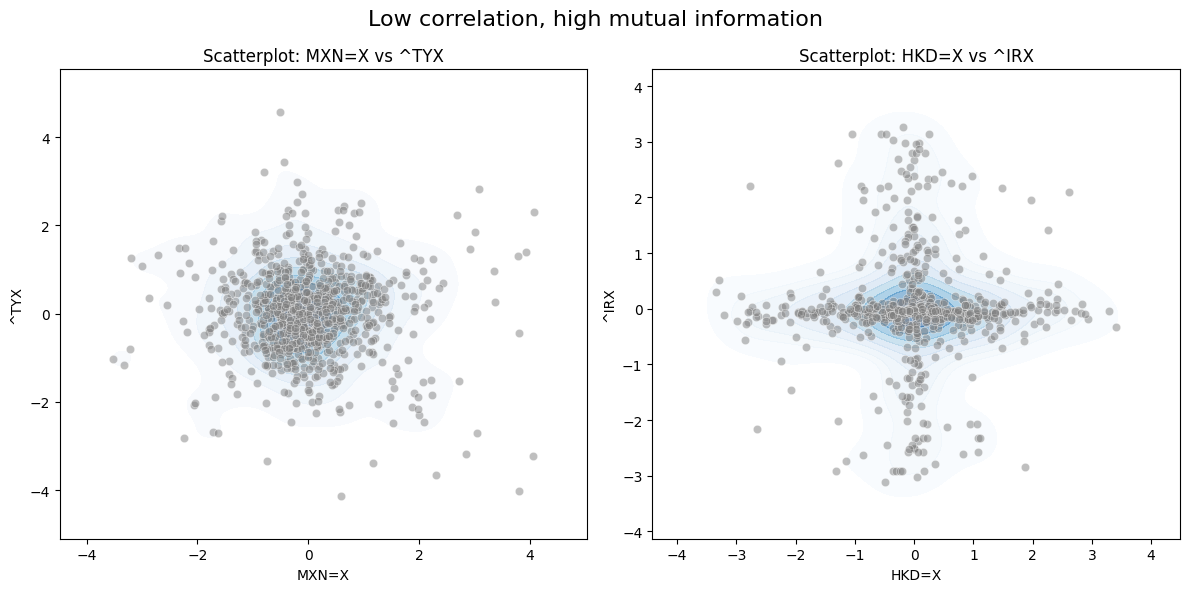

In [11]:
def kde_and_scatterplot(x, y, ax=None, title=""):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(x=x, y=y, ax=ax, cmap="Blues", fill=True, alpha=0.5, levels=10)
    sns.scatterplot(x=x, y=y, color="gray", alpha=0.5, ax=ax)
    ax.set_title(title) # , fontsize=12, pad=5

def kde_and_scatterplot_for_returns(assets_returns, suptitle):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.flatten()

    for i, asset_pair in enumerate(assets_returns.index[0:2]):
        print(f'Asset pair: {asset_pair}')
        print(f"Corr(X, Y) = {assets_returns.loc[asset_pair]['Corr(X, Y)']}, I(X, Y) = {assets_returns.loc[asset_pair]['I(X, Y)']}")
        print(df_stocks_info[df_stocks_info['symbol'].isin(asset_pair)][['symbol','shortName']]) # Added for convinience
        print('\n')
        x = df_cleaned[asset_pair[0]]
        y = df_cleaned[asset_pair[1]]

        kde_and_scatterplot(x, y, axes[i], f"Scatterplot: {asset_pair[0]} vs {asset_pair[1]}")

    fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout()

    plt.show()

kde_and_scatterplot_for_returns(assets_returns = top_mutual_info, 
                                suptitle = "Low correlation, high mutual information")



Asset pair: ('^HSI', '^IRX')
Corr(X, Y) = 0.01, I(X, Y) = 0.05
    symbol              shortName
743   ^IRX  13 WEEK TREASURY BILL
758   ^HSI        HANG SENG INDEX


Asset pair: ('HKD=X', '^AXJO')
Corr(X, Y) = -0.01, I(X, Y) = 0.06
    symbol          shortName
723  HKD=X            USD/HKD
760  ^AXJO  S&P/ASX 200 [XJO]




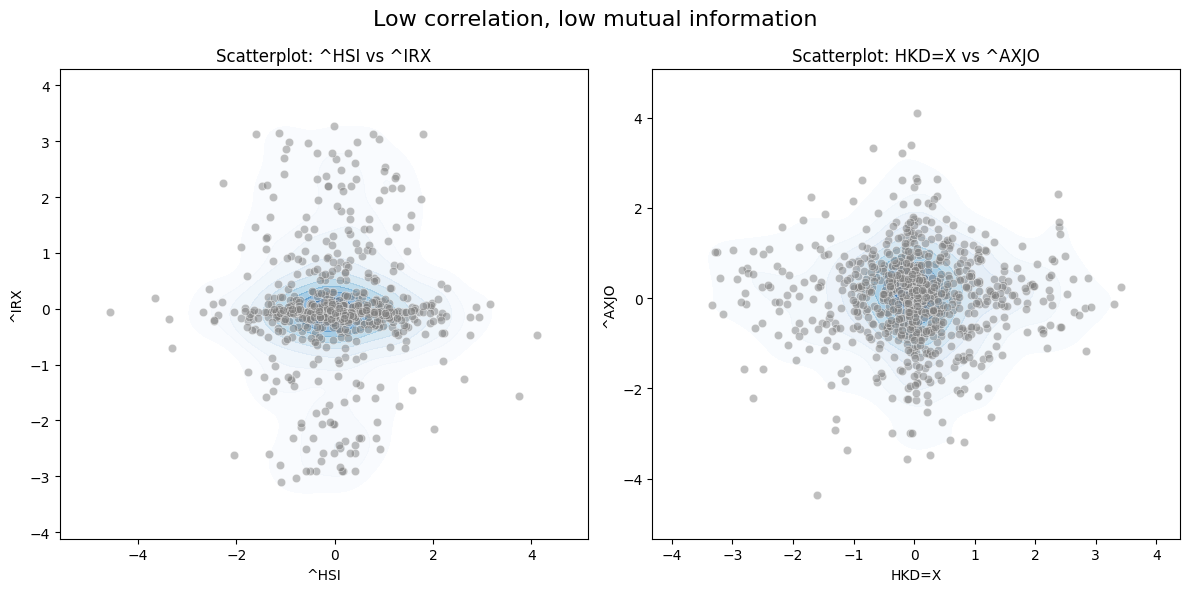

In [12]:
kde_and_scatterplot_for_returns(assets_returns = low_mutual_info, 
                                suptitle = "Low correlation, low mutual information")

### Scatterplots of the analyzed measures

We observe a clear connection among all the metrics. This can be explained by the fact that, for stocks with log-returns following a near-normal distribution, correlation fully captures dependency.

Additionally, information-based metrics exhibit a fairly linear relationship with entropy. For instance, in the case of conditional entropy, a higher joint entropy naturally leads to a higher conditional entropy, even when one variable is known.

However, KL divergence and cross-entropy do not follow this linear pattern, as they measure the relative difference between distributions rather than the absolute notion of surprise.

In [13]:
# Calculating the information driven measures for all assets
corr_matrix = df_cleaned.corr()

asset_pairs = []

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.index:
        if col1 < col2:
            low_corr_pairs.append((col1, col2))

results = {}
for asset_pair in low_corr_pairs:
    xy = df_cleaned.loc[:,[asset_pair[0], asset_pair[1]]].dropna()
    x = xy[asset_pair[0]]
    y = xy[asset_pair[1]]
    corr0, _ = pearsonr(x, y)
    corr_metric0 = corr_metric(x, y)
    entropy_metrics0 = entropy_metrics(x, y, same_bins = True)
    kl_metrics0 = kl_metrics(x, y)
    results[asset_pair] =  (round(corr0, 2),) + (round(corr_metric0, 2),) + \
        tuple(round(value, 2) for value in entropy_metrics0) + tuple(round(value, 2) for value in kl_metrics0)
    
columns = ["Corr(X, Y)", "Corr metr.", "H(X)", "H(Y)", "H(X, Y)", "H(X|Y)", "H(Y|X)", "I(X, Y)", "VI(X, Y)", "VIB(X, Y)", "KL div", "Cross-entr."]
df_measures_all_assets = pd.DataFrame(results, index=columns).T

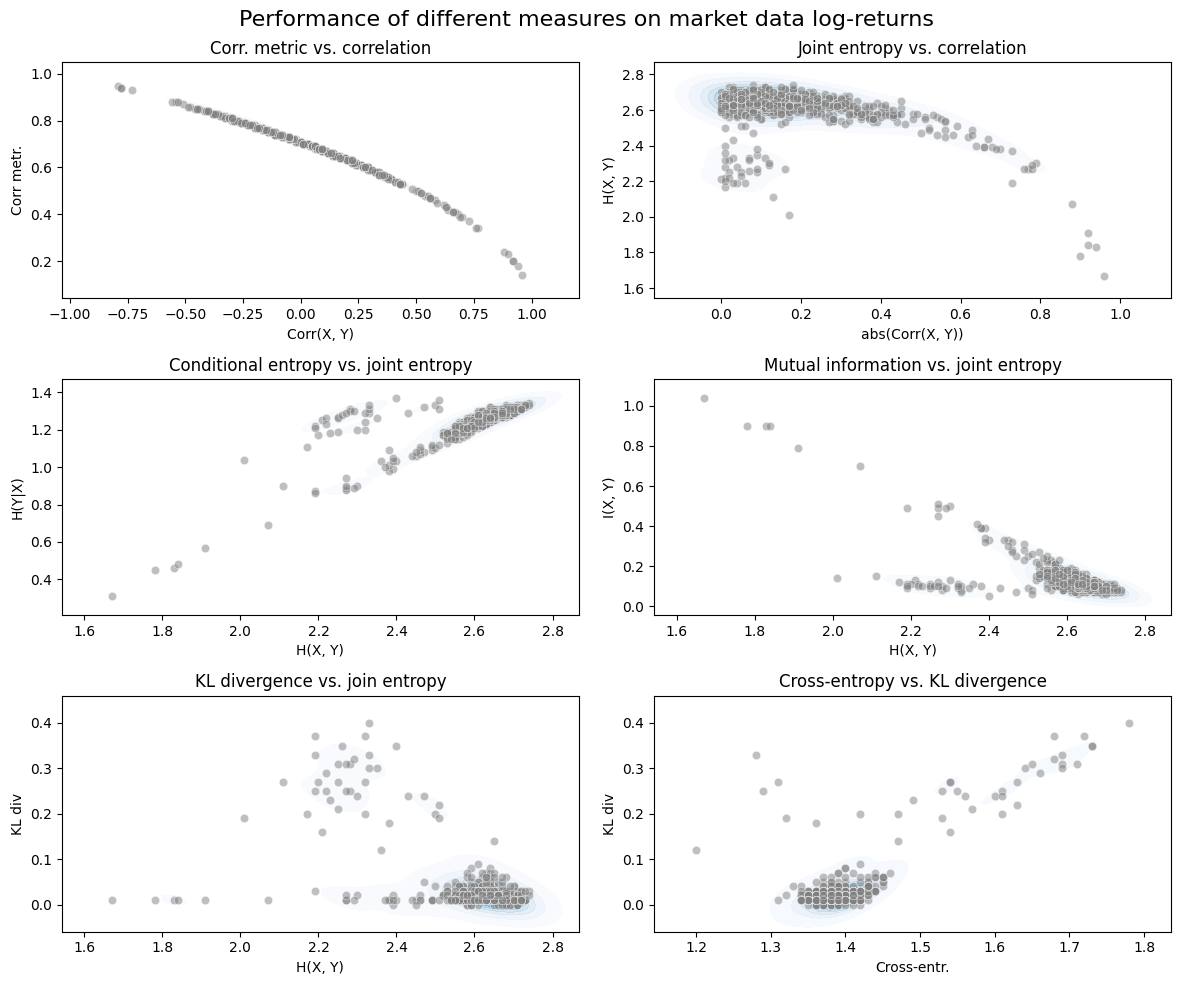

In [14]:
# Plotting the scatterplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# Correlation based metric
x = df_measures_all_assets['Corr(X, Y)']
y = df_measures_all_assets['Corr metr.']
kde_and_scatterplot(x, y, ax=axes[0], title="Corr. metric vs. correlation")

# Joint entropy
x = abs(df_measures_all_assets['Corr(X, Y)']); x.name = 'abs(Corr(X, Y))'
y = df_measures_all_assets['H(X, Y)']
# x = remove_outliers(x, IQR_multiplier = 3.5)
# y = remove_outliers(y, IQR_multiplier = 3.5)
kde_and_scatterplot(x, y, ax=axes[1], title="Joint entropy vs. correlation")

# Conditional entropy
x = abs(df_measures_all_assets['H(X, Y)'])
y = df_measures_all_assets['H(Y|X)']
kde_and_scatterplot(x, y, ax=axes[2], title="Conditional entropy vs. joint entropy")

# Mutual info
x = abs(df_measures_all_assets['H(X, Y)'])
y = df_measures_all_assets['I(X, Y)']
kde_and_scatterplot(x, y, ax=axes[3], title="Mutual information vs. joint entropy")

# Variation of information
x = abs(df_measures_all_assets['H(X, Y)'])
y = df_measures_all_assets['KL div']
kde_and_scatterplot(x, y, ax=axes[4], title="KL divergence vs. join entropy")

# Variation of information
x = abs(df_measures_all_assets['Cross-entr.'])
y = df_measures_all_assets['KL div']
kde_and_scatterplot(x, y, ax=axes[5], title="Cross-entropy vs. KL divergence")

fig.suptitle('Performance of different measures on market data log-returns', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.2)
plt.tight_layout()